In [1]:
import os


os.chdir('../../experiments')

# print("Current working directory:", os.getcwd())

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import random


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:

directory = "../data"
files = os.listdir(directory)
files

['CustomColoredFashionMNIST', 'FashionMNIST', 'MNIST']

In [4]:
grey_transform = transforms.Compose([
    # Convert grayscale to 3-channel RGB
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
                         )  # Normalize for 3 channels

])

In [5]:
train_batch_size = 64
test_batch_size = 128

In [6]:
grey_train_dataset = datasets.FashionMNIST(
    directory, train=True, download=True, transform=grey_transform)

grey_test_dataset = datasets.FashionMNIST(
    directory, train=False, transform=grey_transform)

grey_train_loader = DataLoader(
    grey_train_dataset, batch_size=train_batch_size, shuffle=True)
grey_test_loader = DataLoader(
    grey_test_dataset, batch_size=test_batch_size, shuffle=False)

In [7]:
sample_image, sample_label = grey_train_dataset[0]
print(f"Sample image shape: {sample_image.shape}, Label: {sample_label}")

Sample image shape: torch.Size([3, 28, 28]), Label: 9


In [8]:

grey_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Ensure 3 channels for input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
                         )  # Normalize for 3 channels
])


class_colors = [
    (255, 0, 0),  # Red for class 0
    (0, 255, 0),  # Green for class 1
    (0, 0, 255),  # Blue for class 2
    (255, 255, 0),  # Yellow for class 3
    (255, 0, 255),  # Magenta for class 4
    (0, 255, 255),  # Cyan for class 5
    (128, 128, 128),  # Gray for class 6
    (255, 128, 0),  # Orange for class 7
    (128, 0, 255),  # Purple for class 8
    (0, 128, 255),  # Sky blue for class 9
]

swapped_class_colors = [
    (0, 255, 0),  # Green for class 0
    (255, 0, 0),  # Red for class 1

    (255, 255, 0),  # Yellow for class 2
    (0, 0, 255),  # Blue for class 3

    (0, 255, 255),  # Cyan for class 4
    (255, 0, 255),  # Magenta for class 5

    (255, 128, 0),  # Orange for class 6
    (128, 128, 128),  # Gray for class 7

    (0, 128, 255),  # Sky blue for class 8
    (128, 0, 255),  # Purple for class 9

]

fashion_mnist_classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

In [9]:

from torch.utils.data import Dataset


class ColoredFashionMNIST(Dataset):
    def __init__(self, dataset, class_colors, transform=None):
        """
        Custom dataset for FashionMNIST with class-based coloring.

        Args:
        - dataset: Torchvision dataset (e.g., FashionMNIST).
        - class_colors: List of RGB tuples for each class.
        - transform: Torchvision transforms to apply to the images.
        """
        self.dataset = dataset
        self.class_colors = class_colors
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the grayscale image and label
        image, label = self.dataset[idx]

        # Apply the transformation (if provided)
        if self.transform:
            image = self.transform(image)

        # Convert grayscale to colored
        colored_image = self.grayscale_to_colored(image, label)

        return colored_image, label

    def grayscale_to_colored(self, image, label):
        """
        Converts a transformed 3-channel normalized tensor to class-colored RGB tensor.

        Args:
        - image: Tensor of shape (3, H, W) with values normalized to (-1, 1).
        - label: Class label to determine color.

        Returns:
        - colored_image: Tensor of shape (3, H, W) with class-specific coloring.
        """
        # De-normalize to range [0, 1]
        image = (image * 0.5) + 0.5

        # Get the RGB color for the class
        color = torch.tensor(
            self.class_colors[label], dtype=torch.float32) / 255.0

        # Scale the image by the class color
        colored_image = image * color.view(3, 1, 1)

        return colored_image

In [10]:


train_fashion_mnist = datasets.FashionMNIST(
    root=directory,
    train=True,
    download=True,
    transform=None
)
test_fashion_mnist = datasets.FashionMNIST(
    root=directory,
    train=False,
    download=True,
    transform=None
)


train_colored_dataset = ColoredFashionMNIST(
    train_fashion_mnist, class_colors, transform=grey_transform)
test_colored_dataset = ColoredFashionMNIST(
    test_fashion_mnist, class_colors, transform=grey_transform)
test_swapped_colored_dataset = ColoredFashionMNIST(
    test_fashion_mnist, swapped_class_colors, transform=grey_transform
)

sample_image, sample_label = train_colored_dataset[0]
print(f"Sample image shape: {sample_image.shape}, Label: {sample_label}")

Sample image shape: torch.Size([3, 28, 28]), Label: 9


In [11]:

colored_train_loader = DataLoader(
    train_colored_dataset, batch_size=train_batch_size, shuffle=True)
colored_test_loader = DataLoader(
    test_colored_dataset, batch_size=test_batch_size, shuffle=False)
swapped_colors_test_loader = DataLoader(
    test_swapped_colored_dataset, batch_size=test_batch_size, shuffle=False
)

visualize

In [12]:
def show_images_from_loader(loader, classes=fashion_mnist_classes, n_images=64):

    # Get a batch of images and labels
    images, labels = next(iter(loader))

    # Select n_images from the batch
    # print(labels)
    images, labels = images[:n_images], labels[:n_images]

    # Create a grid of images
    grid = utils.make_grid(images, nrow=int(
        n_images**0.5), padding=2, normalize=True)

    plt.figure(figsize=(8, 8))
    # Convert from (C, H, W) to (H, W, C) for plotting
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Sample Images from Dataset")

    for i, label in enumerate(labels):
        row, col = divmod(i, int(n_images**0.5))
        plt.text(col * (grid.size(2) / n_images**0.5) + 5,
                 row * (grid.size(1) / n_images**0.5) + 5,
                 classes[label.item()],
                 color='white', fontsize=9, ha='center', bbox=dict(facecolor='black', alpha=0.6))
    plt.show()

In [13]:
images, labels = next(iter(colored_train_loader))
# pick the first image
image = images[0]
print(image.shape, type(image))

torch.Size([3, 28, 28]) <class 'torch.Tensor'>


In [14]:
image.max(), image.min(), image.mean(), image.std()

(tensor(1.), tensor(0.), tensor(0.1355), tensor(0.2472))

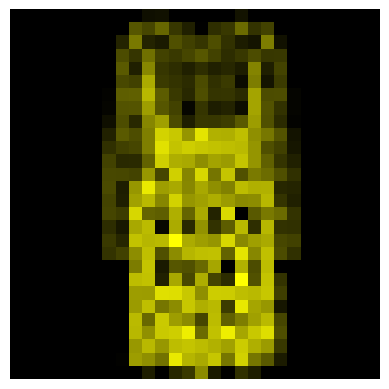

In [ ]:


def plt_image(image):
    plt_image = image.permute(1, 2, 0).numpy()
    plt.imshow(plt_image)
    plt.axis('off')
    plt.show()


plt_image(image)

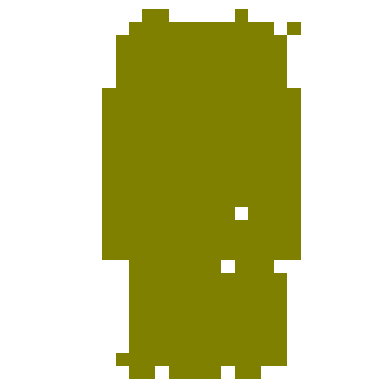

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5].


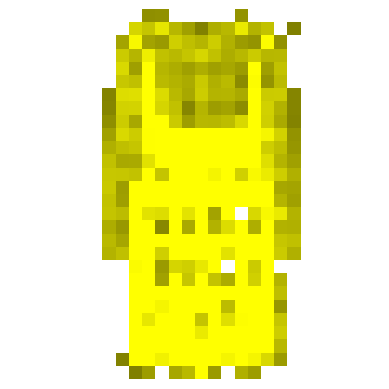

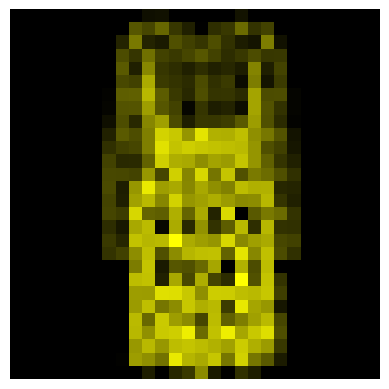

In [ ]:
og_image = images[0].clone()


def rgb_normalize(img):
    h, w = img.shape[1], img.shape[2]
    for i in range(h):
        for j in range(w):
            R = img[0][i][j]
            G = img[1][i][j]
            B = img[2][i][j]
            # value = (R + G + B) / 3
            value = R + G + B
            img[0][i][j] = R/value
            img[1][i][j] = G/value
            img[2][i][j] = B/value
    return img


rgb_normalized_image = rgb_normalize(image)
plt_image(rgb_normalized_image)
plt_image(og_image + rgb_normalized_image)
plt_image(og_image)